# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import pymc3 as pm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

from functools import partial
from scipy import stats, interpolate

from src.data import generate_dataset
from src.visualization import beautify_ax
from src.models import BayesianLinearRegression, DeepQuantileRegression
from src.models.quantile_utils import create_quantiles, get_quantile_pred, QuantileLoss

%load_ext autoreload
%autoreload 2

# Generating data

In [2]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

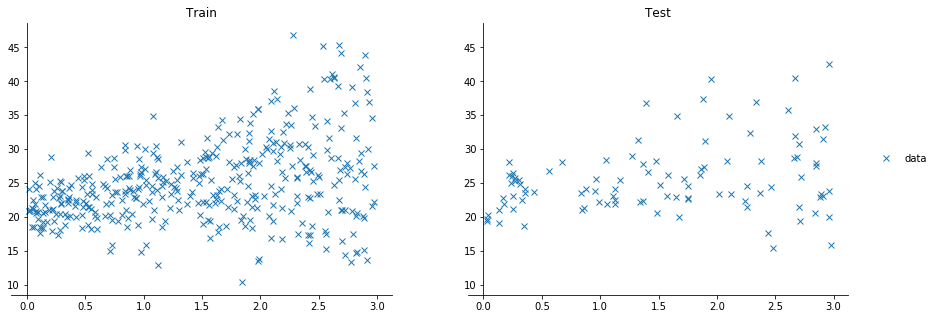

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data

In [4]:
mmsx = MinMaxScaler()
x = mmsx.fit_transform(x)
x_test = mmsx.transform(x_test)

mmsy = MinMaxScaler()
y = mmsy.fit_transform(y)
y_test = mmsy.transform(y_test)

## Loading trace/predictions from BLR model

In [5]:
fname_trace = '../models/BLR.trace'
blr = BayesianLinearRegression()
blr.load_trace(fname_trace)

In [6]:
blr_preds_train = blr.predict(x)
blr_preds_test = blr.predict(x_test)

blr_preds_test.shape, blr_preds_train.shape

100%|██████████| 4000/4000 [00:36<00:00, 108.92it/s]


((4000, 100, 1), (4000, 400, 1))

## Quantile regression neural network, using MCDropout (in PyTorch)
Setting up:
- model, model config
- data loader/generator

In [7]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
print(f"Used quantiles: {QUANTILES}")
params = {
    'input_size': 1,
    'hidden_size': 128,
    'dropout_p': 0.2,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 2001,
    'lr': 1e-4,
    'weight_decay': 1e-6,
}
dqr = DeepQuantileRegression(params)
dqr.load(path='../models/', fname='deep_quantile_regression.pth')

Used quantiles: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]


DeepQuantileRegression(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Dropout_on_dim(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=11, bias=True)
  )
)

## Predict

In [8]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

dqr_preds_train = dqr.mc_predict(x_train, samples=4000).numpy()
dqr_preds_test = dqr.mc_predict(x_val, samples=4000).numpy()

dqr_preds_test.shape, dqr_preds_train.shape

((4000, 100, 11), (4000, 400, 11))

## Some postprocessing

In [9]:
sorted_index_train = x.argsort(axis=0).flatten()
x_sorted = x[sorted_index_train]
blr_preds_train, dqr_preds_train = blr_preds_train[:, sorted_index_train, :], dqr_preds_train[:, sorted_index_train, :]

sorted_index_test = x_test.argsort(axis=0).flatten()
x_test_sorted = x_test[sorted_index_test]
blr_preds_test, dqr_preds_test = blr_preds_test[:, sorted_index_test, :], dqr_preds_test[:, sorted_index_test, :]

## Comparing the 'fit' of the two methods on the train set

Calculating the mean $\mu +/- 2 * \sigma$ for the bayesian linear regression

In [10]:
mu = np.transpose(blr.trace['alpha'] + blr.trace['beta'] * x)[:, sorted_index_train]
sigma = np.squeeze(blr.trace['sigma'], axis=-1)[:, sorted_index_train]
quantile_preds = np.array([
    mu - 2 * sigma, 
    mu - 1 * sigma,
    mu, 
    mu + 1 * sigma, 
    mu + 2 * sigma
]).T
quantile_preds = np.swapaxes(quantile_preds, 0, 1)  # to make it shape (samples, train_size, quantiles)

calculating the median $q_{0.5}$, $q_{0.025}$ and $q_{0.975}$ to approximate $\mu +/- 2 * \sigma$ (using [this rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule))

In [11]:
q_975 = np.array([
    get_quantile_pred(q=.975, used_quantiles=QUANTILES, preds=dqr_preds_train[i, ...]) 
    for i in range(dqr_preds_train.shape[0])
])

q_025 = np.array([
    get_quantile_pred(q=.025, used_quantiles=QUANTILES, preds=dqr_preds_train[i, ...]) 
    for i in range(dqr_preds_train.shape[0])
])

median_i = int(QUANTILES.shape[-1]/2)
q_50 = dqr_preds_train[:, :, median_i]

## Plotting median and credible interval (2$*\sigma$)
You can see that they are similar, but there are two major differences. First, the Quantile regression model has more spread (epistemic uncertainty). This can be because we only have 1 inpute feature, and still using dropout to sample. The other thing is that the bayesian model's lower and upper margin are more parralel to the mean. This is because these boundaries are dependent on the mean (eventhough sigma is also dependent on $x$). Because we individually estimate the quantiles on the quantile regresesion model, you can see that the lines are a little more divergent. This comparison is therefore not completely fair, but it gives the first insight in the differences between the two approaches.

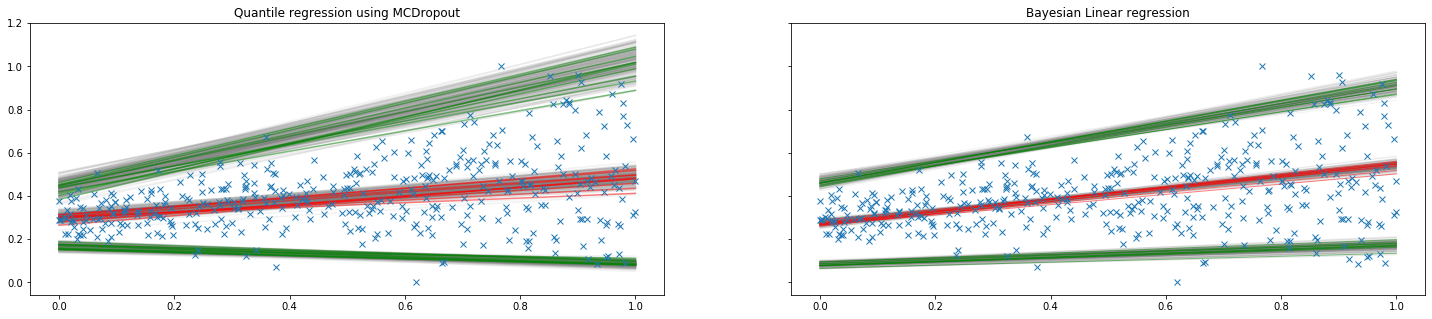

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25,5))
n = 200
n_c = 10

axes[0].plot(x_sorted, q_025[:n].T, c='grey', alpha=.1)
axes[0].plot(x_sorted, q_50[:n].T, c='grey', alpha=.1)
axes[0].plot(x_sorted, q_975[:n].T, c='grey', alpha=.1)
axes[0].plot(x_sorted, q_025[n:n+n_c].T, c='green', alpha=.5)
axes[0].plot(x_sorted, q_50[n:n+n_c].T, c='red', alpha=.5)
axes[0].plot(x_sorted, q_975[n:n+n_c].T, c='green', alpha=.5)
axes[0].plot(x, y, 'x')
axes[0].set_title('Quantile regression using MCDropout')

axes[1].plot(x_sorted, mu[:n].T, alpha=.1, lw=1, c='grey')
axes[1].plot(x_sorted, quantile_preds[:n, :, 0].T, alpha=.1, lw=1, c='grey')
axes[1].plot(x_sorted, quantile_preds[:n, :, -1].T, alpha=.1, lw=1, c='grey')
axes[1].plot(x_sorted, mu[n:n+n_c].T, alpha=.5, lw=1, c='red')
axes[1].plot(x_sorted, quantile_preds[n:n+n_c, :, 0].T, alpha=.5, lw=1, c='green')
axes[1].plot(x_sorted, quantile_preds[n:n+n_c, :, -1].T, alpha=.5, lw=1, c='green')
axes[1].plot(x, y, 'x')
axes[1].set_title('Bayesian Linear regression');

## Looking at individual predictions (on test set)
The quantile regressions predicts the quantiles (by design, although we have to take the mean of all cdfs produced by `mc_predict()`), but we have to find the same quantiles from the posterior distribution prediction from the bayesian linear regression model. 
The distributions seem very similar. Maybe we need to plot them in a PDF form.

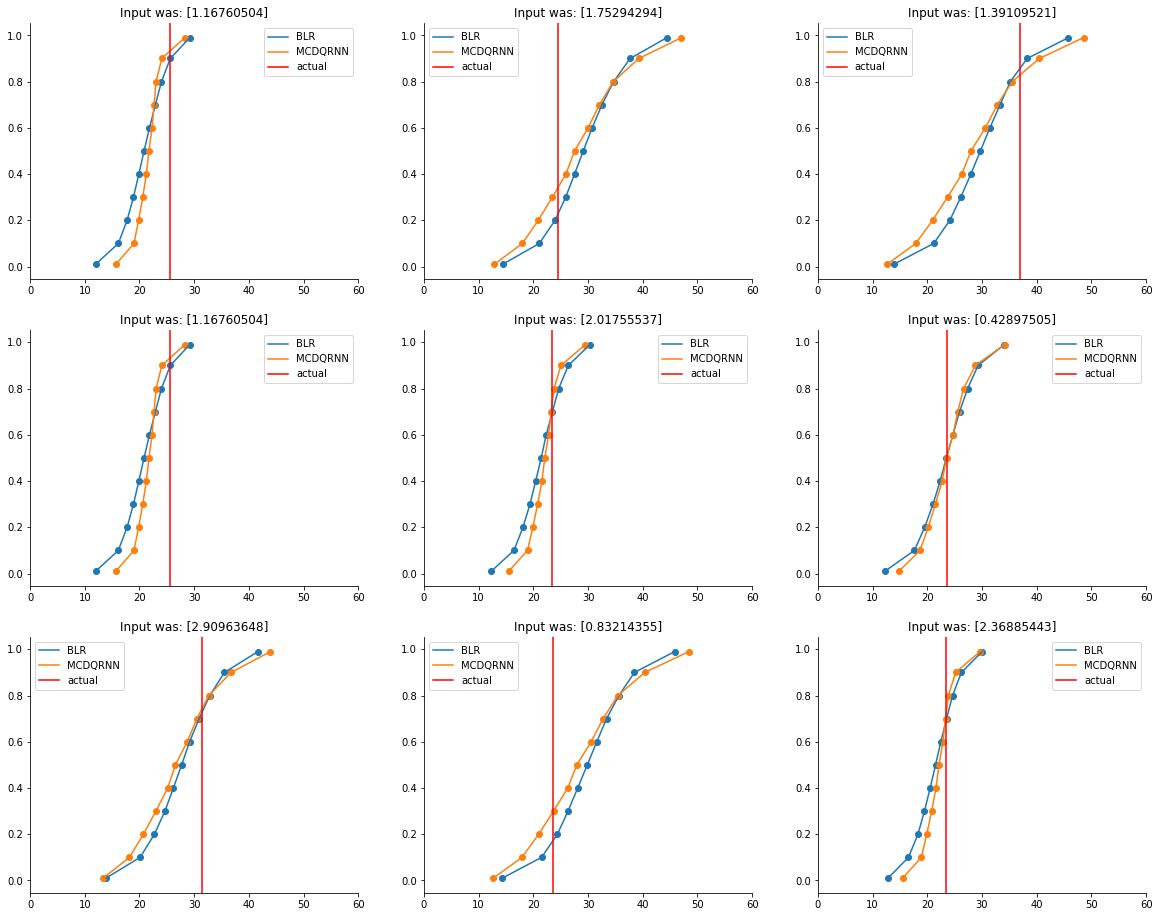

In [13]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, 100)
    ax = beautify_ax(ax)
    
    blr_posterior = mmsy.inverse_transform(blr_preds_test[:, i, 0].reshape(-1,1))
    qs_from_posterior = np.quantile(blr_posterior, QUANTILES)
    ax.plot(qs_from_posterior, QUANTILES, label='BLR')
    ax.scatter(qs_from_posterior, QUANTILES)
    
    mean_qs = np.mean(dqr_preds_test[:, i, :], axis=0)
    dqr_posterior = mmsy.inverse_transform(mean_qs.reshape(-1,1))
    ax.plot(dqr_posterior, QUANTILES, label='MCDQRNN')
    ax.scatter(dqr_posterior, QUANTILES)
    
    ax.axvline(mmsy.inverse_transform(y_test)[i], c='r', label='actual')
    ax.set_title(f"Input was: {mmsx.inverse_transform(x_test)[i]}")
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()

## Looking at individual predictions - part 2
You can see that the distributions are normally distributed, with different levels of uncertainty. (higher input value of $x$ should result into higher uncertainty). The difference is still difficult to determine. In these samples, the MCDQRNN seems to be overly confident on some predictions, and sometimes with more probability mass towards the edges of the distribution. Maybe we need another plot to compare! At least we can see that both approaches are really similar!

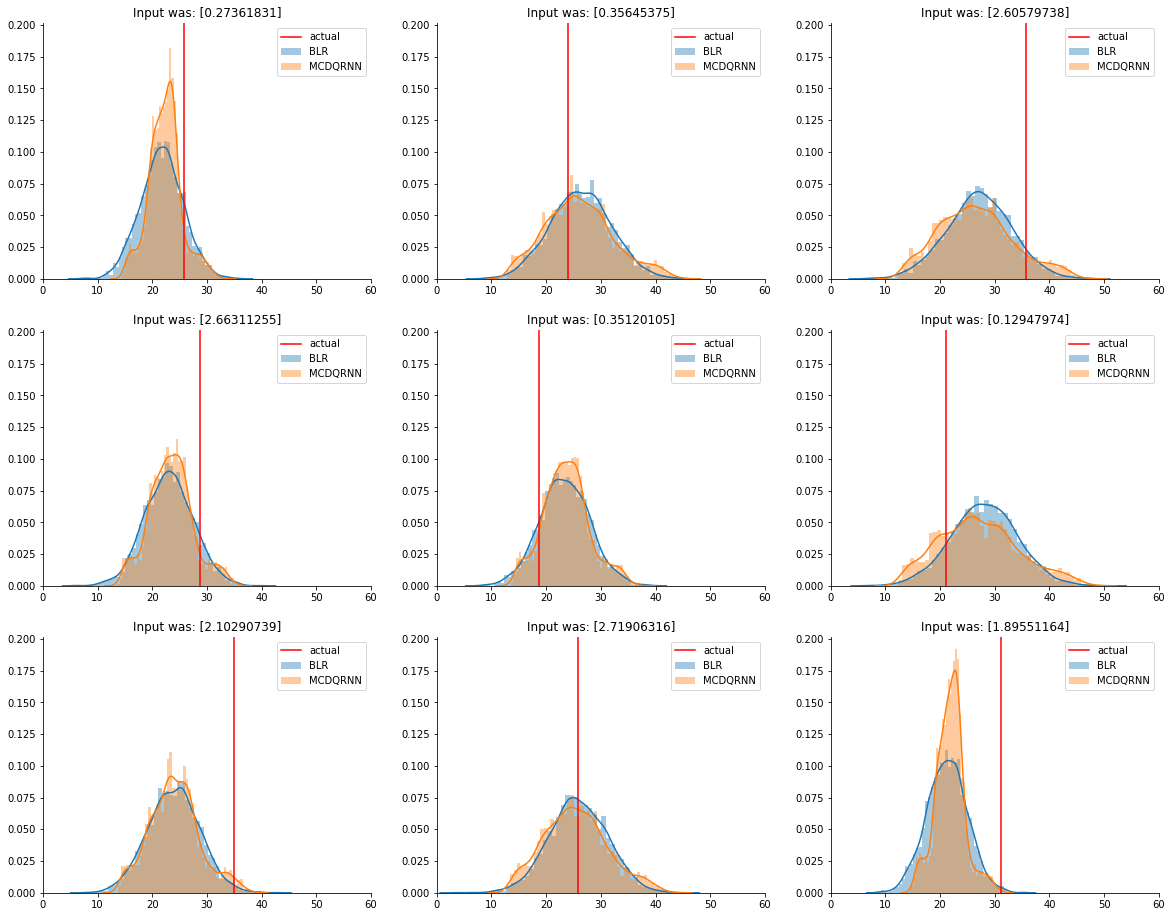

In [14]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, x_test.shape[0])
    ax = beautify_ax(ax)
    
    blr_posterior = mmsy.inverse_transform(blr_preds_test[:, i, 0].reshape(-1,1))
    sns.distplot(blr_posterior, bins=50, ax=ax, label='BLR')
    
    dqr_posterior = np.array([
        get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=dqr_preds_test[s, i, :])
        for s in range(dqr_preds_test.shape[0])  # sample from all samples
    ])
    dqr_posterior = mmsy.inverse_transform(dqr_posterior.reshape(-1,1))
    sns.distplot(dqr_posterior, bins=50, ax=ax, label='MCDQRNN')
    
    ax.axvline(mmsy.inverse_transform(y_test)[i], c='r', label='actual')
    ax.set_title(f"Input was: {mmsx.inverse_transform(x_test)[i]}")
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()

## Looking at point predictions
As a simple metric, we could compare single point predictions by taking the mean of the predicted posterior distribution. This point is the best value to represent the probability distribution. We could then for example compare the Mean Absolute Error (MAE).

In [26]:
dqr_posteriors = []
for i in tqdm(range(x_test.shape[0])):
    dqr_posteriors.append(np.array([
        get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=dqr_preds_test[s, i, :])
        for s in range(dqr_preds_test.shape[0])  # sample from all samples
    ]))
dqr_mean_preds = np.mean(np.stack(dqr_posteriors), axis=-1)
dqr_mean_preds = mmsy.inverse_transform(dqr_mean_preds.reshape(-1,1))

In [33]:
blr_mean_preds = mmsy.inverse_transform(np.mean(blr_preds_test, axis=0))

The point estimates predictions are really similar!

In [38]:
print("MAE - MCDQRNN : {}".format(mean_absolute_error(y_test, dqr_mean_preds)))
print("MAE - BLR     : {}".format(mean_absolute_error(y_test, blr_mean_preds)))

MAE - MCDQRNN : 24.772366230785988
MAE - BLR     : 24.973759700152076


Until now, we've only visually compared the uncertainty (distributions). But how do we formally evaluate the uncertainty of the model? This is something I will dive into next.